In [15]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable
import numpy as np

import cvxpy as cp
import MPC_prob
from utils import *
import pickle, os
from MPC_prob import MPC
from model_train import train

from tqdm import tqdm
from para import paraset
from sampling import sampling
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set prob parameters and save at MPC.config

In [66]:
N = 8
n_obs = 5
paraset(N=N,n_obs=n_obs,Qs=1,Rs=0,num_probs=20000,obs_default=True)

## Solve MICP problems to get samlpings for training

In [18]:
sampling(N,n_obs)

  0%|          | 8/20000 [00:01<41:42,  7.99it/s]  C:\Users\msi\anaconda3\envs\coco\lib\site-packages\cvxpy\problems\problem.py:1306: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)
  0%|          | 51/20000 [00:04<28:44, 11.57it/s]


KeyboardInterrupt: 

## Load train/test data

### Test problem parameters

In [51]:
## test 10 problems
n_prob = 10

dataset_name = 'MPC_horizon_{}_obs_{}'.format(N,n_obs)
relative_path = os.getcwd()
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')
config_file = open(config_fn,'rb')
config=pickle.load(config_file)

prob = MPC(config=config_fn)

## set initial position and final position
# x0 = [3.5,1.75,0,0]
# xg = [2,2.5,0,0]

dataset_name, prob_params, sampled_params, n_obs, num_probs, border_size, box_buffer, min_box_size, max_box_size, posmin, posmax, velmin, velmax, n, m,obs_fix, xg_fix, obstacles = config

solvetime = 0
for i in range(n_prob):
    x0 = findIC(obstacles,posmin,posmax,velmin,velmax)
    xg = findIC(obstacles,posmin,posmax,velmin,velmax)

    prob_params = {}
    prob_params['obstacles'] =  np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
    prob_params['x0'] = x0
    prob_params['xg'] = xg
    prob = MPC(config=config_fn)

    _, _, solvetime_g, optvals_g = prob.solve_stl(prob_params, solver=cp.GUROBI,verbose=False)
    solvetime += solvetime_g
print('Ava solve time: '+str(solvetime/n_prob))

Ava solve time: 0.14374866485595703


In [67]:
#load train/test data
dataset_name = 'MPC_horizon_{}_obs_{}'.format(N,n_obs)

#加载设置文件地址，config = [dataset_name, prob_params, sampled_params]#
relative_path = os.getcwd()
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')

config_file = open(config_fn,'rb')
config=pickle.load(config_file)

dataset_name =  config[0]
prob_params = config[1]
sampled_params = config[2]
config_file.close()

### Load training&testing data

In [68]:
relative_path = os.getcwd()
dataset_name = 'MPC_horizon_{}_obs_{}'.format(N,n_obs)
dataset_fn = relative_path + '/data/' + dataset_name

##load train data
train_file = open(dataset_fn + '/train_horizon_{}.p'.format(N), 'rb')
# train_file = open(dataset_fn+'/train.p','rb')
train_data = pickle.load(train_file)
p_train, x_train, u_train, y_train, z_train, cost_train, times_train = train_data
train_file.close()

##load test data
test_file = open(dataset_fn + '/test_horizon_{}.p'.format(N), 'rb')
# test_file = open(dataset_fn+'/test.p','rb')
# p_test, x_test, u_test, y_test, c_test, times_test = pickle.load(test_file)
test_data = pickle.load(test_file)
p_test, x_test, u_test, y_test, z_test, cost_test, times_test = test_data
test_file.close()

### Load netwrok

In [69]:
from solvers.OMISTL import OMISTL

system = 'MPC'
prob_features = ['x0','xg','obstacles']
# prob_features = ['x0','xg','obstacles_map']
relative_path = os.getcwd()
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')
config_file = open(config_fn,'rb')
config=pickle.load(config_file)
prob = MPC(config=config_fn)

MPC_obj = OMISTL(system, prob, prob_features)

n_features = 2*prob.n*(len(prob_features)-1)+n_obs*4+n_obs
MPC_obj.construct_strategies(n_features, train_data)
print('Find number of strategires: '+ str(MPC_obj.n_strategies))

MPC_obj.setup_network()
fn_saved = '..\models/MPC_horizon_{}_obs_{}.pt'.format(N,n_obs)
MPC_obj.load_network(fn_saved)

Find number of strategires: 707
Loading presaved classifier model from ..\models/MPC_horizon_8_obs_5.pt


True

## Train model

In [25]:
MPC_obj.training_params['TRAINING_ITERATIONS'] = 500
MPC_obj.train(train_data=train_data, verbose=True)
MPC_obj.model

loss:   0.22991608083248138,   acc:  0.9375
loss:   0.4046410322189331,   acc:  0.84375
Done with epoch 0 in 12.489405632019043s
loss:   0.35257357358932495,   acc:  0.84375


KeyboardInterrupt: 

### train model with different horizons

In [23]:
# train(N,n_obs)

nubmber of strategies:241
n_obs: 10
N: 6
Loading presaved classifier model from ..\models\MPC_horizon_6_obs_10.pt
model already exist


### Set problem and test dataset

In [70]:
velmin = -0.2
velmax = 0.2
posmin = np.zeros(2)

ft2m = 0.3048
posmax = ft2m*np.array([12.,9.])
max_box_size = 0.75
min_box_size = 0.25
box_buffer = 0.025
border_size = 0.05

obstacles = config[-1]
# obstacles = \
#         random_obs(n_obs, posmin, posmax, border_size, box_buffer, min_box_size, max_box_size)

## Calculating shortest path using network

In [73]:
obstacles

[array([1.25, 2.  , 1.2 , 1.5 ]),
 array([1.25, 1.75, 0.2 , 1.  ]),
 array([0.3, 0.8, 1.5, 2. ]),
 array([2.5 , 3.25, 1.6 , 2.  ]),
 array([2.9 , 3.25, 2.  , 2.25])]

In [74]:
prob_success = False
prob = MPC(config=config_fn)
## set initial position and final position
x0 = [3.5,1.75,0,0]
xg = [2,2.5,0,0]
# x0 = findIC(obstacles, posmin=posmin, posmax=posmax, velmin=velmin, velmax=velmax)
# xg = findIC(obstacles, posmin=posmin, posmax=posmax, velmin=velmin, velmax=velmax)

##
while not prob_success:
    prob_params = {}
    prob_params['obstacles'] =  np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
    prob_params['x0'] = x0
    prob_params['xg'] = xg
    prob_success, cost, total_time, n_evals, optvals,y_guess = MPC_obj.forward(prob_params, solver=cp.GUROBI, max_evals=10)
    if prob_success:
        Xopt = optvals[0]

_, _, solvetime_g, optvals_g = prob.solve_stl(prob_params, solver=cp.GUROBI)
# _, _, solvetime_m, optvals_g = prob.solve_stl(prob_params, solver=cp.MOSEK)

print('Machine learning solve time (red points) : '+ str(total_time))
print('Gurobi solve time (blue points): '+ str(solvetime_g))
# print('MOSEK solve time: '+ str(solvetime_m))

Machine learning solve time (red points) : 0.015626907348632812
Gurobi solve time (blue points): 0.1406230926513672


## Plot

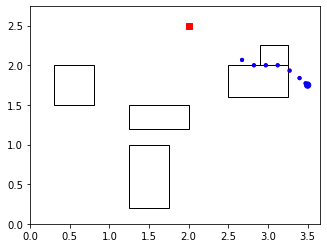

In [75]:
Xopt_g = optvals_g[0]

obstacles = []
for ii_obs in range(n_obs):
    obs = prob_params['obstacles'][:,ii_obs]
    obstacles.append(obs)

if len(obstacles) is n_obs:
    plt.axes()
    for obstacle in obstacles:
        rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                                  obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                                 fc='white', ec='black')
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')


    xg = prob_params['xg']
    x0 = prob_params['x0']
    circle = plt.Circle((x0[0],x0[1]), 0.04, fc='blue',ec="blue")
    plt.gca().add_patch(circle)

    #blue line is network prediction
    plt.plot(xg[0],xg[1],'sr')
    # plt.quiver(Xopt[0,:], Xopt[1,:], Xopt[2,:], Xopt[3,:])#plot using arrows
    for jj in range(N):
        circle = plt.Circle((Xopt[0,jj],Xopt[1,jj]), 0.02, fc='red',ec="red")
        plt.gca().add_patch(circle)

    #red line is Gurobi
    for jj in range(N):
        circle = plt.Circle((Xopt_g[0,jj],Xopt_g[1,jj]), 0.02, fc='blue',ec="blue")
        plt.gca().add_patch(circle)

    ax = plt.gca()
    ax.margins(0)
    ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
    plt.show()

## MPC control

### Set initial point and reference point

In [76]:
## set initial points and reference points
ref_list = []
num_ref = 3
x0 = [0.5,0.5,0,0]

#use default reference points
ref_1 = [0.6,2.3,0,0]
ref_list.append(ref_1)
ref_2 = [3.5,2.2,0,0]
ref_list.append(ref_2)
ref_3 = [3,1,0,0]
ref_list.append(ref_3)

# or generate reference points use different random seeds
# seed = 2
# for i in range(num_ref):
#     ref = list(findIC(obstacles, posmin=posmin, posmax=posmax, velmin=velmin, velmax=velmax, seed =i+seed))
#     ref[2]=0
#     ref[3]=0
#     ref_list.append(ref)
ref_list

[[0.6, 2.3, 0, 0], [3.5, 2.2, 0, 0], [3, 1, 0, 0]]

In [77]:
from MPC_control import MPC_controller

mpc_time = 600
prob = MPC(config=config_fn)

Xopt,Uopt,Yopt,T_total = MPC_controller(x0,ref_list,prob=prob,MPC_obj=MPC_obj,T=mpc_time)

Found solution at t =  0. n_evals = 1
Found solution at t =  1. n_evals = 1
Found solution at t =  2. n_evals = 1
Found solution at t =  3. n_evals = 1
continue original path at t= 4
continue original path at t= 5
continue original path at t= 6
continue original path at t= 7
continue original path at t= 8
continue original path at t= 9
Found solution at t =  10. n_evals = 1
Found solution at t =  11. n_evals = 1
Found solution at t =  12. n_evals = 1
Found solution at t =  13. n_evals = 1
Found solution at t =  14. n_evals = 1
Found solution at t =  15. n_evals = 1
Found solution at t =  16. n_evals = 1
Found solution at t =  17. n_evals = 1
Found solution at t =  18. n_evals = 1
Found solution at t =  19. n_evals = 1
continue original path at t= 20
continue original path at t= 21
continue original path at t= 22
continue original path at t= 23
continue original path at t= 24
continue original path at t= 25
continue original path at t= 26
Found solution at t =  27. n_evals = 10
Found so

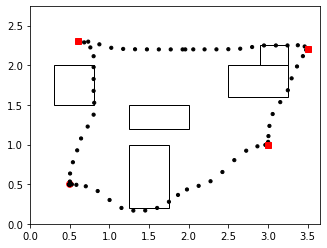

total solving time for 600 steps is 3.217233419418335
avarage solving time at each step is 0.005362055699030558


In [78]:
#plot results
obstacles = []
x0 = [0.5,0.5,0,0]
x_init = x0
for ii_obs in range(n_obs):
    # obs = test_data[0]['obstacles'][idx][:,ii_obs]
    obs = prob_params['obstacles'][:,ii_obs]
    obstacles.append(obs)

# x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
x0 = prob_params['x0']
xg = prob_params['xg']


if len(obstacles) is n_obs:
    plt.axes()
    for obstacle in obstacles:
        rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                                  obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                                 fc='white', ec='black')
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')

    circle = plt.Circle((x_init[0],x_init[1]), 0.04, fc='red',ec="red")
    plt.gca().add_patch(circle)

    for i in range(num_ref):
        plt.plot(ref_list[i][0],ref_list[i][1],'sr')
    #plot using arrows
    # for jj in range(len(Xopt[:,0])):
    #     plt.quiver(Xopt[jj][0], Xopt[jj][0])
    #     circle = plt.Circle((Xopt[jj][0],Xopt[jj][1]), 0.02, fc='blue',ec="blue")

    # for jj in range(len(Xopt[:,0])):
    #     plt.quiver(Xopt[jj][0], Xopt[jj][1], Xopt[jj][2], Xopt[jj][3])

    for jj in range(len(Xopt[:,0])):
        circle = plt.Circle((Xopt[jj][0],Xopt[jj][1]), 0.02, fc='black',ec="black")
        plt.gca().add_patch(circle)

    ax = plt.gca()
    ax.margins(0)
    ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
    plt.show()

print('total solving time for {} steps is '.format(mpc_time) +str(T_total))
print('avarage solving time at each step is ' +str(T_total/mpc_time))